In [2]:
!pip install nmrglue

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 3.7 MB/s eta 0:00:00


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 246


/usr/local/lib/python3.10/dist-packages/nmrglue/analysis/peakpick.py:386: ComplexWarning: Casting complex values to real discards the imaginary part
  scale.append(float(sc))
/usr/local/lib/python3.10/dist-packages/nmrglue/fileio/table.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  new_rec[name] = col.astype(format)
<ipython-input-109-4555b75fb853>:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(np.real(spectrum[left:right]), frequencies[left:right])
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


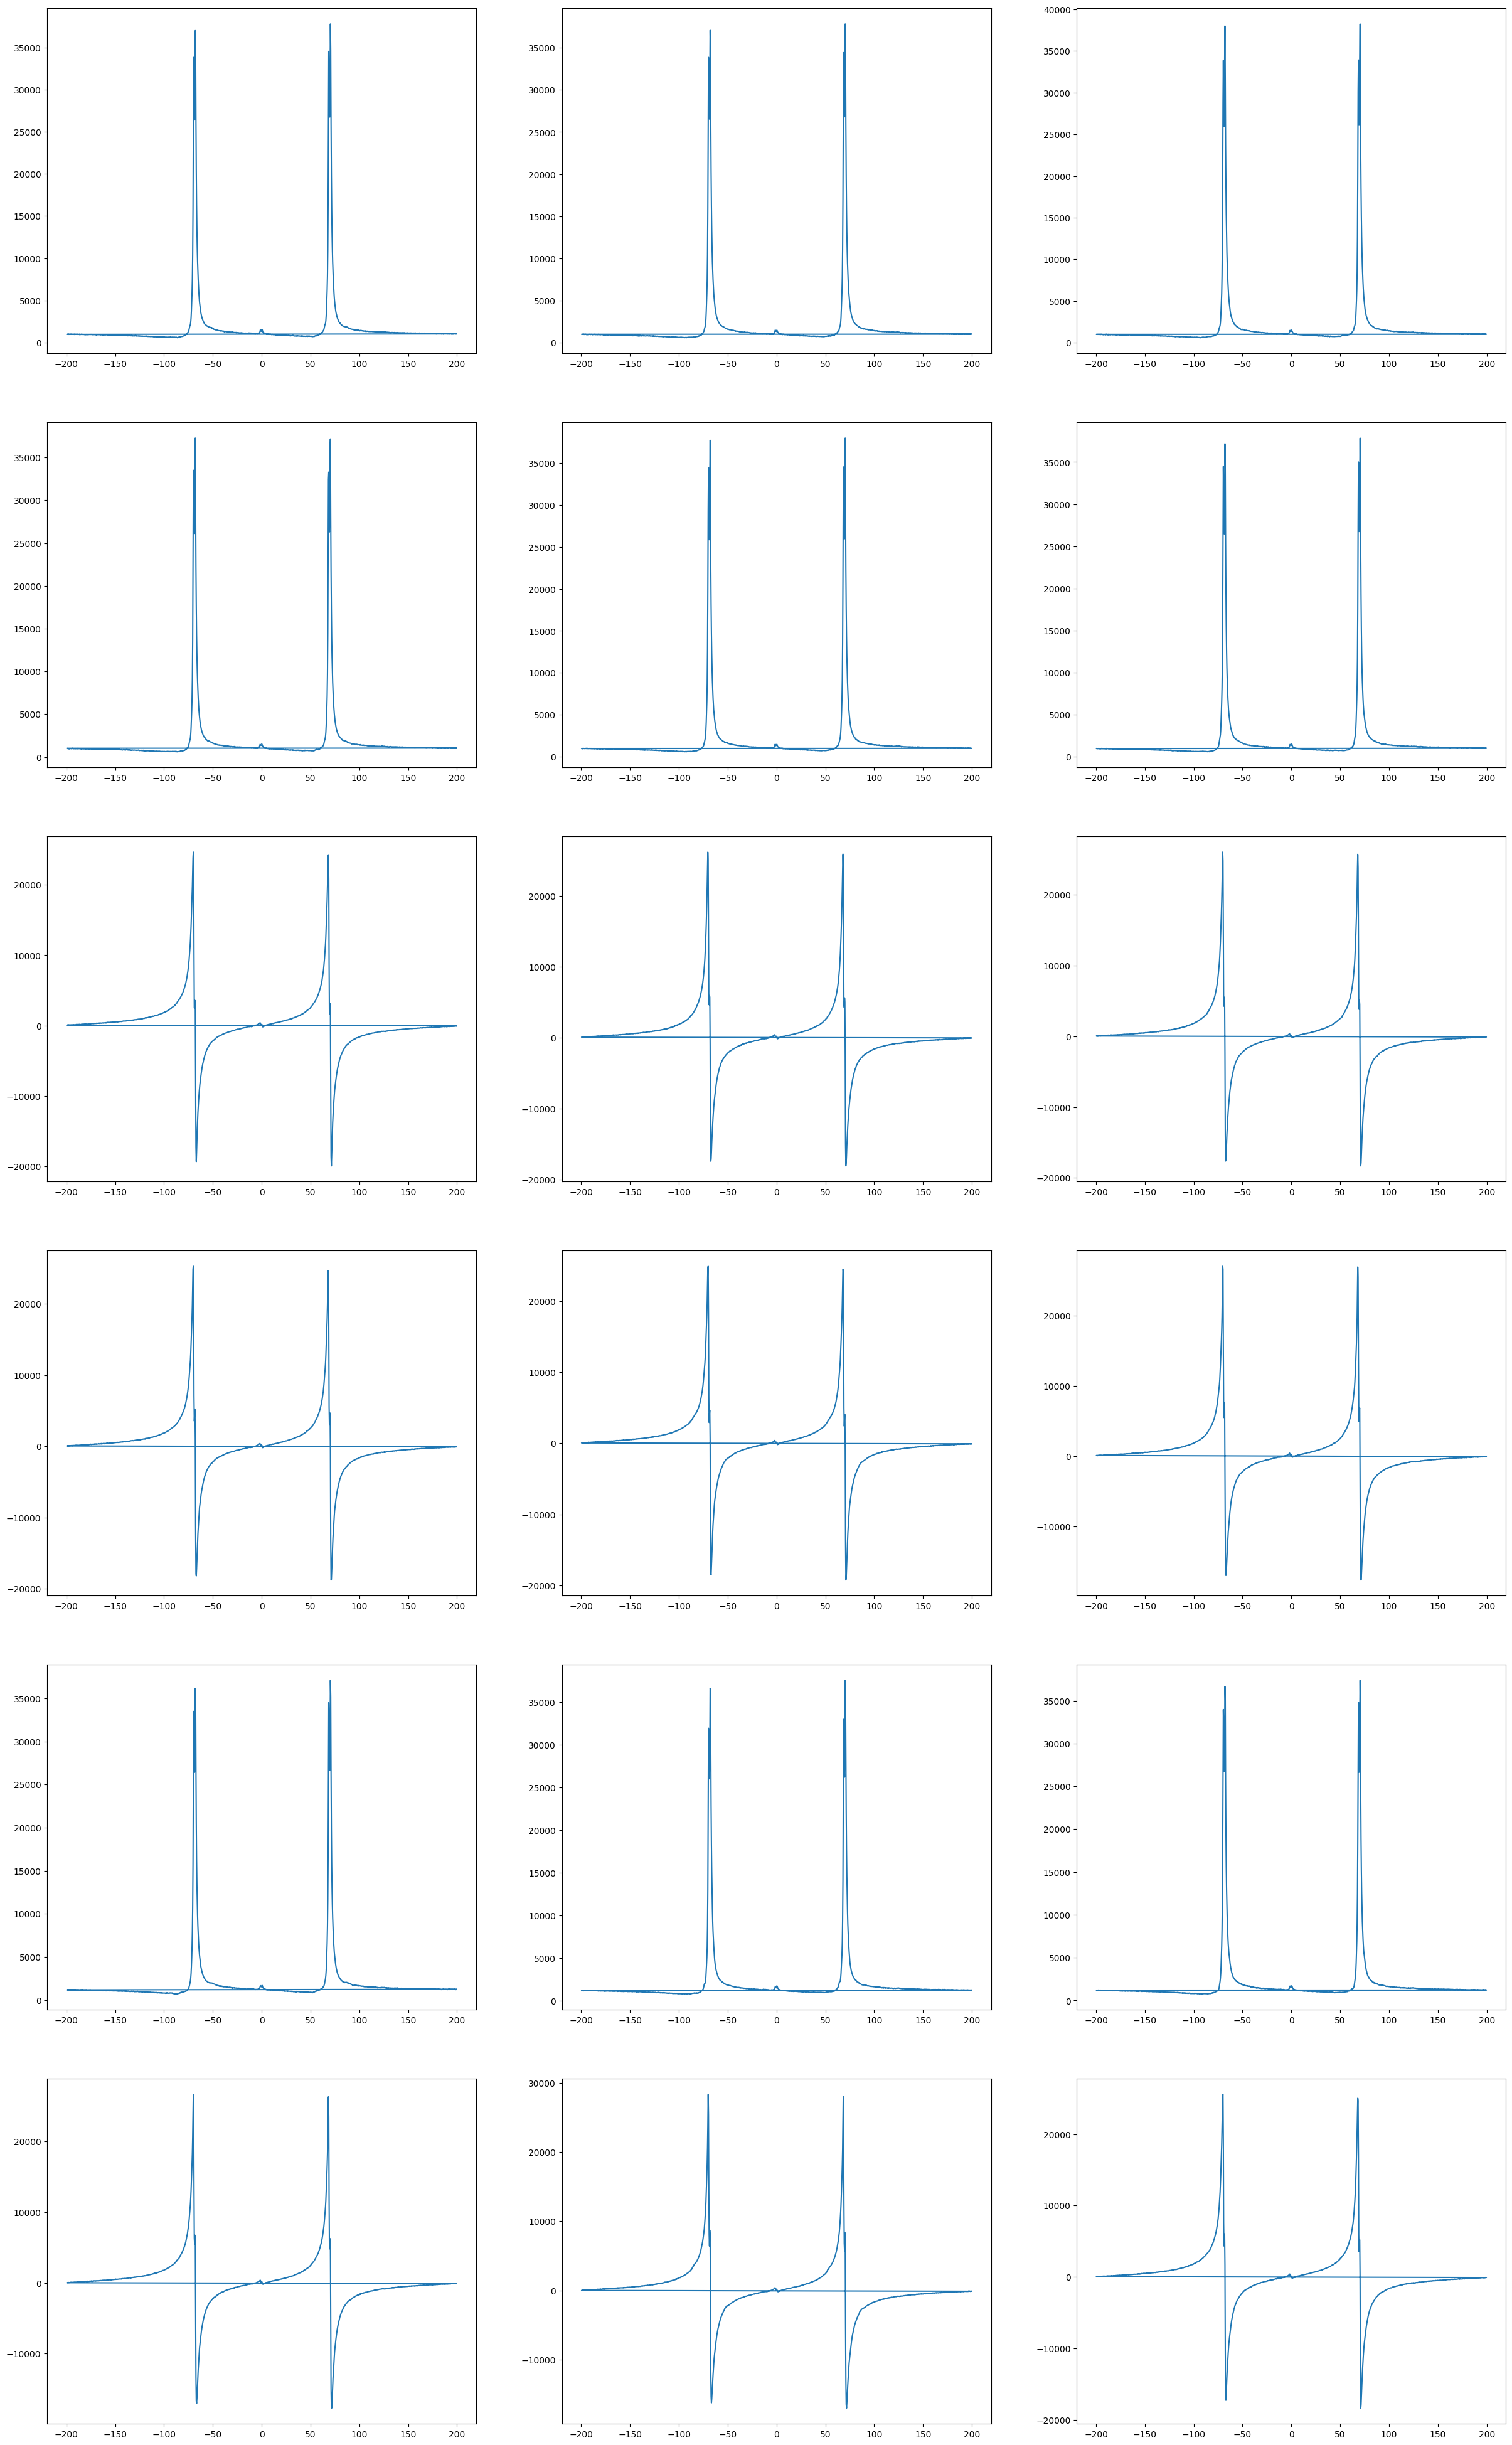

In [109]:
from scipy.integrate import simps
import pathlib as pth
import numpy as np
import nmrglue as ng
from matplotlib import pyplot as plt
import pandas as pd


def proper_phases(data):
    spectrum_unpr = np.fft.fft(data[0])
    spectrum, phases = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
    return phases

def identity_operator_idx(data):
    max_vals = []
    for i in range(len(data)):
        spectrum_unpr = np.fft.fft(data[i])
        maxima = max(np.real(spectrum_unpr))
        max_vals.append(maxima)
    threshold = np.mean(maxima) / 100
    indices = [i for i, value in enumerate(max_vals) if value < threshold]
    return indices

tn = 'H' # Название исследуемого ядра

dic, data = ng.varian.read(r'test')
df = pd.read_csv('dict.csv')
filtered_df = df[df['nucleus'] == tn]
at = float(dic['procpar']['at']['values'][0])
peak_width = filtered_df['peak_width'].values[0]
center = filtered_df['center'].values[0]
region = filtered_df['borders'].values[0]

phases = proper_phases(data)
id_idx = identity_operator_idx(data)
n = len(data[0])
time = np.linspace(0, at, n)
dt = at / n

frequencies = np.fft.fftfreq(n, d=dt)
dnu = frequencies[1] - frequencies[0]
peak_idx_width = int(peak_width / dnu)
mask = (frequencies >= center-region) & (frequencies <= center+region)
frequencies = frequencies[mask]

integrated_areas = []
fig, axs = plt.subplots(6, 3, figsize=(30, 50))
axs = axs.flatten()
spectras = []
peaks = []

for idx in range(len(data)):
    if idx not in id_idx and idx != 0:
        spectrum = np.fft.fft(data[idx])[mask]
        corrected_spectrum = spectrum * np.exp(1j * 2 * np.pi / 360 * (phases[0]))
        normalized_spectrum = spectrum / max(spectrum)
        loc_peaks = ng.analysis.peakpick.pick(normalized_spectrum, 0.07, -0.07, table=True)
        iter = 1
        for peak in loc_peaks:
            left = int(peak[0] - peak_idx_width)
            right = int(peak[0] + peak_idx_width)
            area = simps(np.real(spectrum[left:right]), frequencies[left:right])
            integrated_areas.append([idx + 1, iter, area])
            iter += 1
        peaks.append(loc_peaks)
        spectras.append(corrected_spectrum)
for idx in range(len(spectras)):
    axs[idx].plot(frequencies, spectras[idx])
    for i in range(len(peaks[idx])):
        s = int(peaks[idx][i][0] + peak_idx_width)
        p = int(peaks[idx][i][0] - peak_idx_width)
        axs[idx].axvline(x=frequencies[s], color='orange', linestyle='--')
        axs[idx].axvline(x=frequencies[p], color='blue', linestyle='--')
plt.show()

In [110]:
integrated_areas

[[8, 1, -62782.57244771518],
 [8, 2, 12106.997361288591],
 [8, 3, -70843.73086194675],
 [8, 4, -92108.14999066608],
 [8, 5, -99918.48231079806],
 [9, 1, -63179.28282194483],
 [9, 2, -71310.05321838029],
 [9, 3, -95600.78566440524],
 [9, 4, -100289.88165260018],
 [10, 1, -61792.75230682702],
 [10, 2, 10198.569484684884],
 [10, 3, -70024.81748244258],
 [10, 4, -94195.44376971525],
 [10, 5, -102184.54370512368],
 [11, 1, -64634.12443747504],
 [11, 2, -69438.44952681688],
 [11, 3, -93349.18250903238],
 [11, 4, -101404.6031215488],
 [12, 1, -61091.26337992368],
 [12, 2, -69461.77179137191],
 [12, 3, -93478.5294139408],
 [12, 4, -101573.56661642008],
 [13, 1, -62566.83133251049],
 [13, 2, -70908.07444077267],
 [13, 3, -91679.33761697264],
 [13, 4, -99745.72333181712],
 [14, 1, 157380.18733489298],
 [14, 2, 152457.80132808944],
 [15, 1, 157022.92703913967],
 [15, 2, 152130.42654562756],
 [15, 3, 51434.57598358764],
 [15, 4, 123815.59891580738],
 [16, 1, 155831.45821855892],
 [16, 2, 150783.94

In [105]:
peaks

[rec.array([( 212.,  2,  6.84252503,   7.97454644),
            (2521.,  6,  2.93856852,   2.78270968),
            (2543.,  7,  4.34929545,   6.24313303),
            (2564.,  8,  5.41633501,   8.73863126),
            (2585.,  9, 37.03154546,  65.14132245),
            (3486., 11,  2.52647399,   0.95540504),
            (3511., 12, 15.36826426,  28.23157533),
            (3817., 14, 12.53819159,  31.11999684),
            (3967., 15,  1.        ,   0.14805534),
            (4282., 18,  3.6555434 ,   1.51021367),
            (4307., 19, 21.48149994,  45.63224112),
            (5796., 20,  7.13087846,   7.39494364),
            ( 203.,  1,  5.23441688,  -2.4039429 ),
            (2485.,  3, 28.09975976, -33.82745988),
            (2496.,  4,  6.38645074,  -1.93348941),
            (2507.,  5,  5.45401576,  -1.86721179),
            (2517.,  6,  6.78201378,  -1.81975675),
            (2538.,  7,  6.3063849 ,  -1.60725478),
            (2560.,  8,  2.6398326 ,  -0.78247495),
            